In [52]:
!pip install geopy
!pip install holidays
!pip install shap
!pip install optuna

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 1000)

import shap
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv')
data = data.sample(1000000)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
print(*data.shape)
print(data.dtypes)
data.head(5)

1000000 8
key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
19879841,2009-06-03 23:13:15.0000002,8.5,2009-06-03 23:13:15+00:00,-73.955935,40.776036,-73.949960,40.806373,1
30070668,2010-01-13 15:52:00.00000078,7.3,2010-01-13 15:52:00+00:00,-73.982463,40.756890,-73.972850,40.758858,2
13632566,2010-05-02 22:24:00.00000097,4.9,2010-05-02 22:24:00+00:00,-73.990132,40.687278,-73.999768,40.678335,1
46522526,2014-01-31 14:47:54.0000003,14.5,2014-01-31 14:47:54+00:00,-73.969174,40.764063,-73.997706,40.729254,1
49062480,2014-11-08 14:58:00.00000064,12.5,2014-11-08 14:58:00+00:00,-73.954580,40.732410,-73.957788,40.711742,5


## Data cleaning before FE

### missing values

In [3]:
def missing_values_table(data):
    mis_val = data.isnull().sum()    
    mis_val_percent = 100 * data.isnull().sum() / len(data)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns = {0 : 'missing values', 1 : '% of total values'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values(
        '% of total values', ascending=False).round(1)
    return mis_val_table

missing_values_table(data)

,missing values,% of total values
dropoff_longitude,2,0.0
dropoff_latitude,2,0.0


In [4]:
print(*data.shape)
data.dropna(inplace=True)
print(*data.shape)

1000000 8
999998 8


### fare amount

count    999998.000000
mean         11.353718
std           9.802018
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

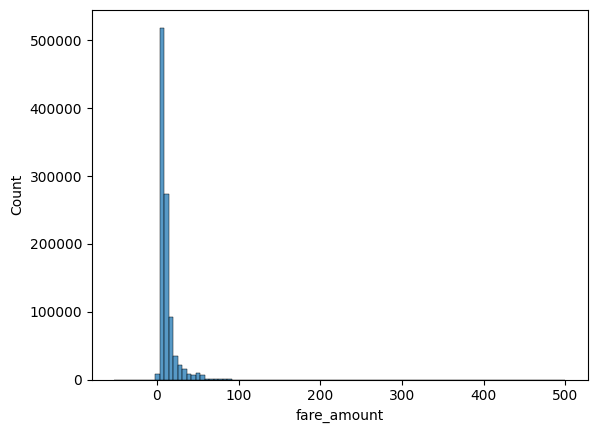

In [5]:
sns.histplot(data=data, x='fare_amount', bins=100);
data['fare_amount'].describe()

In [6]:
print(*data.shape)
data = data[data['fare_amount'].between(0, 100)]
print(*data.shape)

999998 8
999606 8


### latitude & longitude

In [7]:
geo_data = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
geo_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,999606.000000,999606.000000,999606.000000,999606.000000
mean,-72.517434,39.932824,-72.518917,39.920457
std,13.651824,8.951082,13.487813,10.557641
min,-3313.468958,-2141.711845,-3313.468958,-3488.026180
25%,-73.992054,40.734901,-73.991394,40.734065
50%,-73.981815,40.752648,-73.980140,40.753187
75%,-73.967097,40.767121,-73.963665,40.768102
max,3429.680623,3329.093653,3368.139830,2950.087992


In [8]:
print(*data.shape)
data = data[(data['pickup_longitude'].between(-90, 90)) &
            (data['pickup_latitude'].between(-90, 90)) &
            (data['dropoff_longitude'].between(-90, 90)) &
            (data['dropoff_latitude'].between(-90, 90))]
print(*data.shape)

999606 8
999550 8


### passenger count

In [9]:
data['passenger_count'].value_counts()

passenger_count
1      692103
2      147417
5       70650
3       43456
4       21452
6       21052
0        3416
208         2
8           1
9           1
Name: count, dtype: int64

In [10]:
print(*data.shape)
data = data[data['passenger_count'].between(1, 6)]
print(*data.shape)

999550 8
996130 8


## Feature Enginnering : Time features

In [11]:
# Извлечение базовых признаков
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour

In [12]:
# Бинарные признаки
import holidays

us_holidays = holidays.US()
def is_holiday(date): 
    return int(date in us_holidays)

data['is_holiday'] = data['pickup_datetime'].apply(is_holiday)
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

data['is_year_start'] = data['pickup_datetime'].dt.is_year_start.astype(int)
data['is_quarter_start'] = data['pickup_datetime'].dt.is_quarter_start.astype(int)
data['is_month_start'] = data['pickup_datetime'].dt.is_month_start.astype(int)
data['is_month_end'] = data['pickup_datetime'].dt.is_month_end.astype(int)

In [13]:
# Циклические признаки
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

In [14]:
# Разбиение на промежутки
def day_part(hour):
    if hour in [4,5]:
        return "dawn"
    elif hour in [6,7]:
        return "early_morning"
    elif hour in [8,9,10]:
        return "late_morning"
    elif hour in [11,12,13]:
        return "noon"
    elif hour in [14,15,16]:
        return "afternoon"
    elif hour in [17,18,19]:
        return "evening"
    elif hour in [20,21,22]:
        return "night"
    elif hour in [23,24,1,2,3]:
        return "midnight"

data['day_part'] = data['hour'].apply(day_part)
dum = pd.get_dummies(data['day_part'], prefix='day_part').astype(int)
data = pd.concat([data, dum], axis=1)
data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,is_holiday,is_weekend,is_year_start,is_quarter_start,is_month_start,is_month_end,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,day_part,day_part_afternoon,day_part_dawn,day_part_early_morning,day_part_evening,day_part_late_morning,day_part_midnight,day_part_night,day_part_noon
19879841,2009-06-03 23:13:15.0000002,8.5,2009-06-03 23:13:15+00:00,-73.955935,40.776036,-73.949960,40.806373,1,2009,6,3,2,23,0,0,0,0,0,0,1.224647e-16,-1.000000,0.974928,-0.222521,-0.258819,0.965926,midnight,0,0,0,0,0,1,0,0
30070668,2010-01-13 15:52:00.00000078,7.3,2010-01-13 15:52:00+00:00,-73.982463,40.756890,-73.972850,40.758858,2,2010,1,13,2,15,0,0,0,0,0,0,5.000000e-01,0.866025,0.974928,-0.222521,-0.707107,-0.707107,afternoon,1,0,0,0,0,0,0,0
13632566,2010-05-02 22:24:00.00000097,4.9,2010-05-02 22:24:00+00:00,-73.990132,40.687278,-73.999768,40.678335,1,2010,5,2,6,22,0,1,0,0,0,0,5.000000e-01,-0.866025,-0.781831,0.623490,-0.500000,0.866025,night,0,0,0,0,0,0,1,0


## Feature Engineering : Geo features

In [15]:
# haversine distance
def haversine(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

data['haversine_distance'] = haversine(data['pickup_latitude'], data['pickup_longitude'], 
                                  data['dropoff_latitude'], data['dropoff_longitude'])

In [16]:
# geodesic distance
from geopy.distance import geodesic

data['geodesic_distance'] = data.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']), 
                                                            (row['dropoff_latitude'], row['dropoff_longitude'])).km, axis=1)

In [17]:
# расстояние до точек интереса
nyc_center = (40.776, -73.971)

data['h_distance_pickup_ny_center'] = haversine(data['pickup_latitude'], data['pickup_longitude'], *nyc_center)
data['g_distance_pickup_ny_center'] = data.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']), 
                                                            nyc_center).km, axis=1)

data['h_distance_dropoff_ny_center'] = haversine(data['dropoff_latitude'], data['dropoff_longitude'], *nyc_center)
data['g_distance_dropoff_ny_center'] = data.apply(lambda row: geodesic((row['dropoff_latitude'], row['dropoff_longitude']), 
                                                            nyc_center).km, axis=1)

In [18]:
# азимут
import math

def azimuth(lat1, lon1, lat2, lon2):
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    x = math.sin(lon2 - lon1) * math.cos(lat2)
    y = (math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon2 - lon1))
    return math.atan2(x, y)

data['azimuth'] = data.apply(lambda row: azimuth(row['pickup_latitude'], row['pickup_longitude'], 
                                                 row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [19]:
# векторные признаки
data['pickup_lat_sin'] = np.sin(np.radians(data['pickup_latitude']))
data['pickup_lat_cos'] = np.cos(np.radians(data['pickup_latitude']))
data['pickup_lon_sin'] = np.sin(np.radians(data['pickup_longitude']))
data['pickup_lon_cos'] = np.cos(np.radians(data['pickup_longitude']))

## Data cleaning after FE & Clustering

In [20]:
data[['h_distance_pickup_ny_center', 'g_distance_pickup_ny_center', 
      'h_distance_dropoff_ny_center', 'g_distance_dropoff_ny_center']].describe()

,h_distance_pickup_ny_center,g_distance_pickup_ny_center,h_distance_dropoff_ny_center,g_distance_dropoff_ny_center
count,996130.000000,996130.000000,996130.000000,996130.000000
mean,110.036391,177.084332,109.695503,176.535125
std,763.861819,1229.256541,762.335023,1226.797695
min,0.017688,0.028533,0.010866,0.017478
25%,1.120220,1.803391,1.150005,1.851035
50%,2.011484,3.235791,2.055583,3.306852
75%,3.290271,5.292088,3.445036,5.541247
max,9374.720906,15067.350046,9376.621062,15070.447857


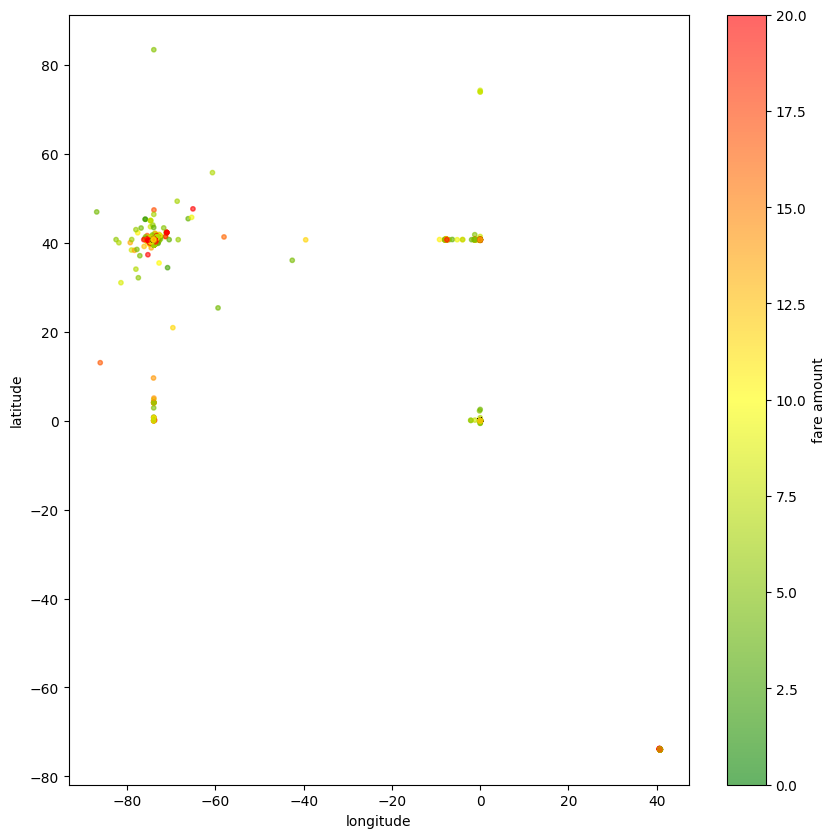

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(name='custom_cmap', colors=['green', 'yellow', 'red'])
plt.figure(figsize=(10, 10))

scatter = plt.scatter(data['pickup_longitude'], data['pickup_latitude'], 
                      c=data['fare_amount'], s=10, cmap=cmap, alpha=0.6, vmin=0, vmax=20)

plt.colorbar(scatter, label='fare amount')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.show()

In [22]:
print(*data.shape)
data = data[data['h_distance_pickup_ny_center'] < 3.29]
print(*data.shape)

996130 45
747037 45


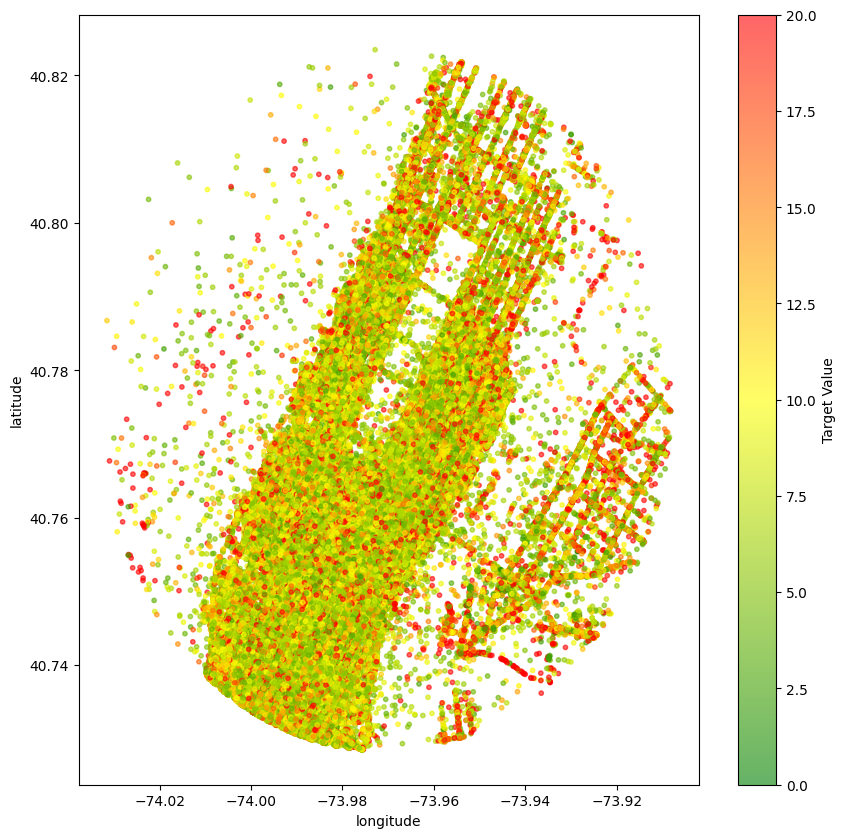

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(name='custom_cmap', colors=['green', 'yellow', 'red'])
plt.figure(figsize=(10, 10))

scatter = plt.scatter(data['pickup_longitude'], data['pickup_latitude'], 
                      c=data['fare_amount'], s=10, cmap=cmap, alpha=0.6, vmin=0, vmax=20)

plt.colorbar(scatter, label='Target Value')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.show()

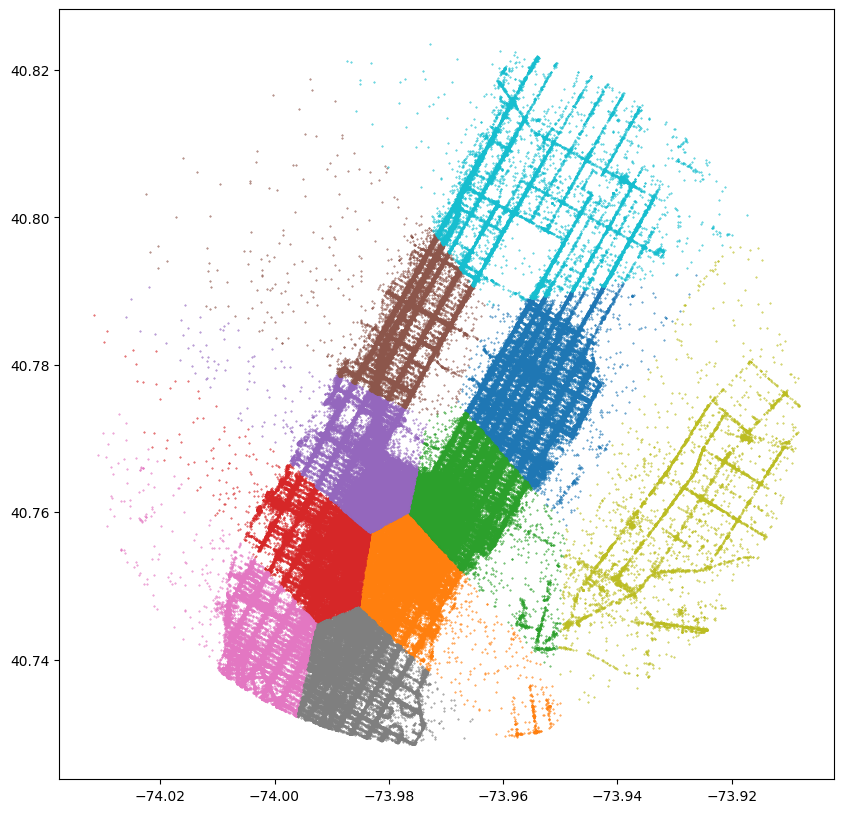

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=3137)
data['cluster'] = kmeans.fit_predict(data[['pickup_latitude', 'pickup_longitude']])
plt.figure(figsize = (10, 10))
for val in data.cluster.unique():
    plt.plot(data.pickup_longitude[data.cluster == val], 
             data.pickup_latitude[data.cluster == val], '.', alpha = 1, markersize = 0.8)

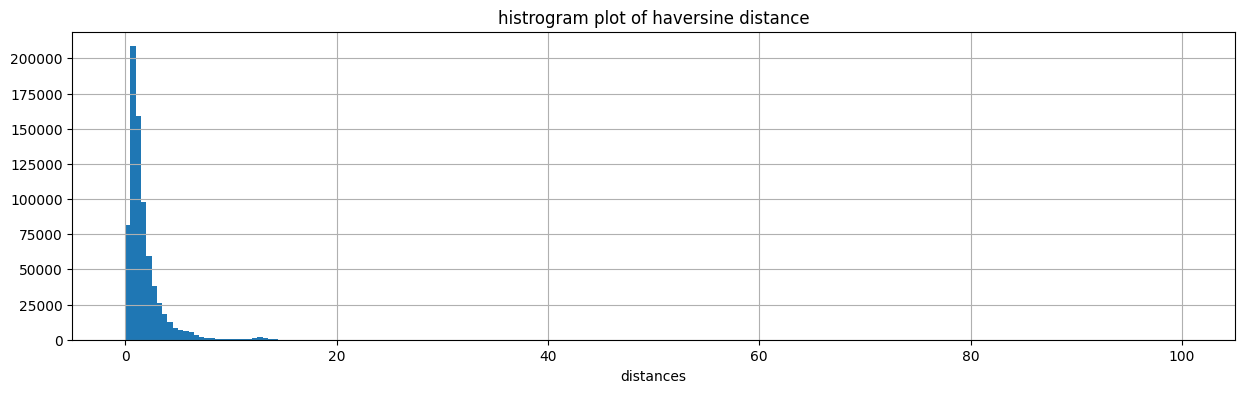

In [25]:
data.haversine_distance.hist(bins=200, figsize=(15,4), range=(0, 100))
plt.xlabel('distances')
plt.title('histrogram plot of haversine distance')
plt.show()

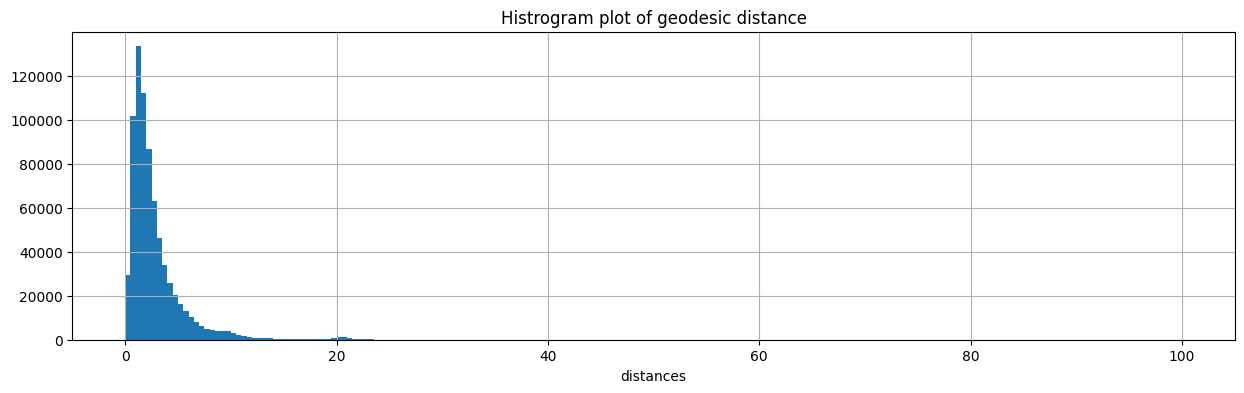

In [26]:
data.geodesic_distance.hist(bins=200, figsize=(15,4), range=(0, 100));
plt.xlabel('distances')
plt.title('Histrogram plot of geodesic distance')
plt.show()

In [27]:
print(*data.shape)
data = data[(data['haversine_distance'] > 0) & (data['geodesic_distance'] > 0)]
print(*data.shape)

747037 46
740338 46


## Training models

In [28]:
X = data.drop(['key', 'pickup_datetime', 'day_part', 'fare_amount'], axis=1)
y = data['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

RMSE: 50.69133130155942
Coefficients: 
 [ 4.73059921e+08  2.11770112e+08 -2.61505604e+01 -1.26769150e+01
  8.28245124e-02  5.00196560e-01  9.61801809e-02  2.96796585e-05
  8.79243319e-02 -1.36973841e-02 -1.37814307e-01 -3.78476312e-01
 -2.08889230e-01  2.10145014e-01 -5.00504315e-02 -2.42042368e-02
  4.80105505e-02 -3.62276600e-02  4.78607108e-02 -8.00177996e-02
  2.20337374e-01 -2.73325349e-01 -1.27267897e-01  2.41873091e+00
 -1.24577096e+00 -4.28085395e-01 -1.09252930e+00  2.00681258e-01
 -3.47894295e-01 -6.39958571e-01 -6.45579875e+02  4.02532708e+02
  1.26840329e+02 -7.80140917e+01  5.41075141e+02 -3.37435662e+02
  2.92021260e-01 -9.18392719e+09  7.92957553e+09 -7.48451909e+09
 -2.60504709e+10 -6.92658722e-02]


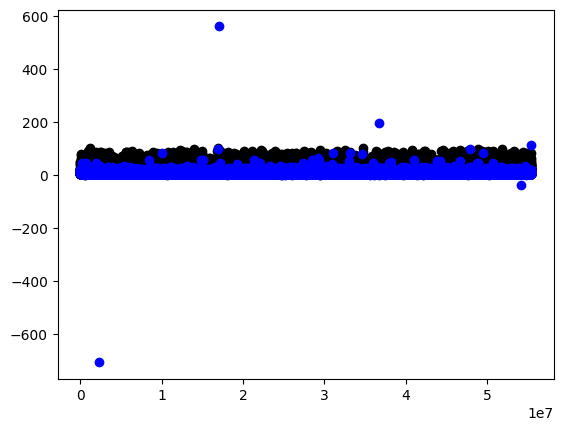

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_pred = lin_reg.predict(X_test)
rmse = mean_squared_error(y_test, lin_reg_pred, squared=True)
print('RMSE:', rmse)

print("Coefficients: \n", lin_reg.coef_)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, lin_reg_pred, color='blue');
plt.show()

Learning rate set to 0.135855
0:	learn: 6.8258261	test: 6.8342420	best: 6.8342420 (0)	total: 150ms	remaining: 2m 29s
100:	learn: 2.8772256	test: 2.8964636	best: 2.8964636 (100)	total: 8.19s	remaining: 1m 12s
200:	learn: 2.7570463	test: 2.8169736	best: 2.8169736 (200)	total: 16s	remaining: 1m 3s
300:	learn: 2.6931994	test: 2.7941240	best: 2.7941240 (300)	total: 23.8s	remaining: 55.3s
400:	learn: 2.6479630	test: 2.7782013	best: 2.7782013 (400)	total: 32.2s	remaining: 48s
500:	learn: 2.6106955	test: 2.7701522	best: 2.7701504 (498)	total: 39.9s	remaining: 39.7s
600:	learn: 2.5786383	test: 2.7659831	best: 2.7659148 (597)	total: 47.4s	remaining: 31.5s
700:	learn: 2.5509165	test: 2.7620421	best: 2.7620421 (700)	total: 55.1s	remaining: 23.5s
800:	learn: 2.5269194	test: 2.7560718	best: 2.7559691 (794)	total: 1m 3s	remaining: 15.8s
900:	learn: 2.5071217	test: 2.7542680	best: 2.7538449 (886)	total: 1m 11s	remaining: 7.82s
999:	learn: 2.4878681	test: 2.7520378	best: 2.7518842 (988)	total: 1m 18s	r

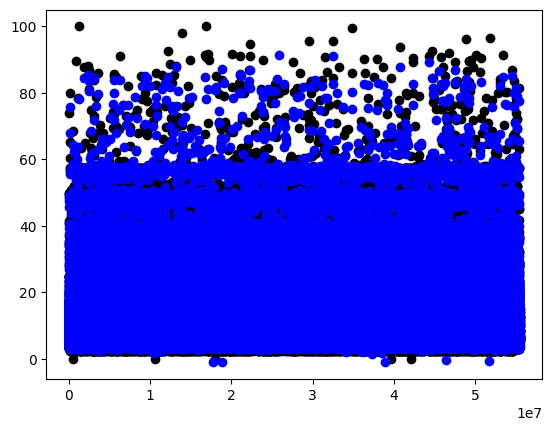

In [30]:
cb_reg = CatBoostRegressor(iterations=1000, 
                          # learning_rate=0.1, 
                          # depth=6, 
                          loss_function='RMSE', 
                          verbose=100,
                          random_state=42)
cb_reg.fit(X_train, y_train, eval_set=(X_test, y_test))
cb_pred = cb_reg.predict(X_test)
rmse = mean_squared_error(y_test, cb_pred, squared=True)
print('RMSE:', rmse)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, cb_pred, color='blue');
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 518236, number of used features: 42
[LightGBM] [Info] Start training from score 10.046788
RMSE: 7.589813888694113


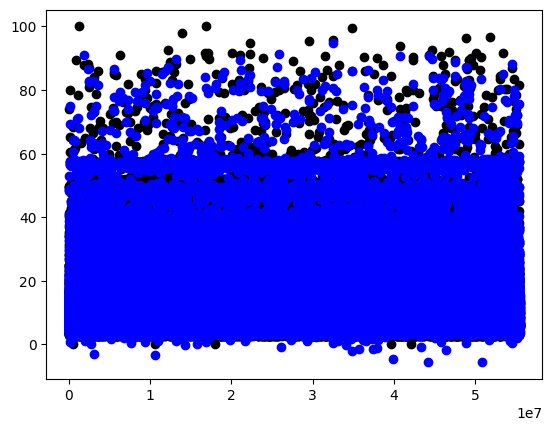

In [32]:
lgbm_reg = LGBMRegressor(n_estimators=1000,
                      n_jobs=-1,
                      verbose=1,
                      random_state=42)
lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)
rmse = mean_squared_error(y_test, lgbm_pred, squared=True)
print('RMSE:', rmse)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, lgbm_pred, color='blue');
plt.show()

RMSE: 7.96476927106199


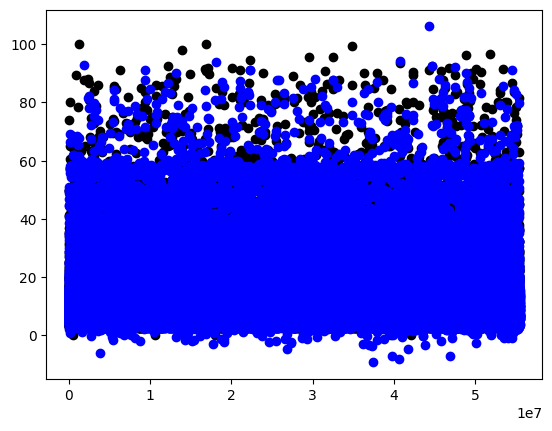

In [33]:
xgb_reg = XGBRegressor(objective='reg:squarederror',
                       n_estimators=1000,
                       random_state=42)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
rmse = mean_squared_error(y_test, xgb_pred, squared=True)
print('RMSE:', rmse)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, xgb_pred, color='blue');
plt.show()

## Feature importance & selection

In [35]:
# feature importance with catboost
importances = cb_reg.get_feature_importance(type='PredictionValuesChange')
importances = pd.Series(importances, index=X.columns).sort_values()[::-1]
importances[:15]

geodesic_distance               24.580967
haversine_distance              22.420758
dropoff_longitude               10.864113
azimuth                         10.077556
year                             6.515035
dropoff_latitude                 5.605947
h_distance_dropoff_ny_center     5.299412
g_distance_dropoff_ny_center     3.226682
hour_cos                         2.255255
month                            0.956780
hour                             0.768135
month_sin                        0.652847
cluster                          0.623877
day                              0.571450
pickup_lat_cos                   0.511858
dtype: float64

In [37]:
# feature importance with shap
explainer = shap.TreeExplainer(cb_reg)
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_importances = shap_df.abs().mean().sort_values(ascending=False)
shap_importances.head(15)

haversine_distance              2.049928
geodesic_distance               2.004297
year                            0.912560
azimuth                         0.739029
cluster                         0.486365
dropoff_longitude               0.482775
hour_cos                        0.360029
pickup_latitude                 0.354628
dropoff_latitude                0.335967
pickup_lat_cos                  0.277483
month                           0.226216
h_distance_dropoff_ny_center    0.174377
g_distance_dropoff_ny_center    0.155187
hour_sin                        0.130198
hour                            0.120447
dtype: float64

## Check feature selection profit

In [44]:
d_imp1 = dict(importances[:15])
d_imp2 = dict(shap_importances[:15])
imp1 = list(d_imp1.keys())
imp2 = list(d_imp2.keys())
best_imp = []
full_imp = []
for col in imp1:
    if col in imp1 and col in imp2:
        best_imp.append(col)
    full_imp.append(col)
for col in imp2:
    if col not in full_imp:
        full_imp.append(col)
for col in best_imp:
    print(col, (d_imp1[col] + d_imp2[col]) / 2)

geodesic_distance 13.292631947117632
haversine_distance 12.235343138350476
dropoff_longitude 5.67344407237511
azimuth 5.40829233986096
year 3.7137975142946673
dropoff_latitude 2.9709569275799557
h_distance_dropoff_ny_center 2.736894080599602
g_distance_dropoff_ny_center 1.690934049432743
hour_cos 1.3076422336169464
month 0.5914979560698049
hour 0.44429094720111423
cluster 0.5551209131878712
pickup_lat_cos 0.3946706504911862


Learning rate set to 0.077684
0:	learn: 7.1363518	test: 7.1419739	best: 7.1419739 (0)	total: 70ms	remaining: 2m 54s
100:	learn: 2.9916355	test: 2.9932308	best: 2.9932308 (100)	total: 5.67s	remaining: 2m 14s
200:	learn: 2.8761602	test: 2.8956453	best: 2.8956453 (200)	total: 11.1s	remaining: 2m 6s
300:	learn: 2.8203383	test: 2.8631748	best: 2.8631748 (300)	total: 17.1s	remaining: 2m 5s
400:	learn: 2.7763462	test: 2.8438703	best: 2.8438703 (400)	total: 22.6s	remaining: 1m 58s
500:	learn: 2.7476329	test: 2.8356737	best: 2.8356737 (500)	total: 28.1s	remaining: 1m 52s
600:	learn: 2.7261018	test: 2.8296792	best: 2.8296792 (600)	total: 33.6s	remaining: 1m 46s
700:	learn: 2.7058379	test: 2.8250572	best: 2.8250572 (700)	total: 38.9s	remaining: 1m 39s
800:	learn: 2.6880670	test: 2.8207206	best: 2.8204627 (799)	total: 44.3s	remaining: 1m 33s
900:	learn: 2.6713532	test: 2.8171310	best: 2.8170063 (898)	total: 50.2s	remaining: 1m 29s
1000:	learn: 2.6567069	test: 2.8152919	best: 2.8152058 (978)	total:

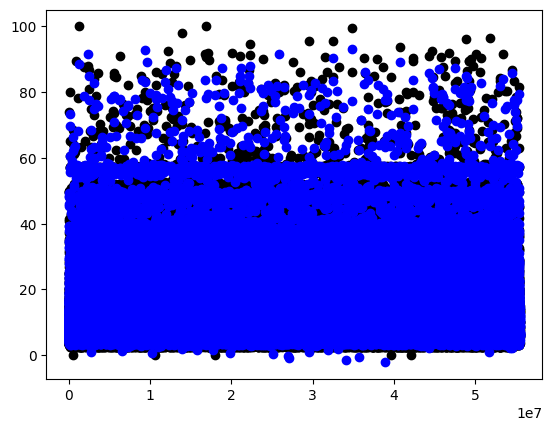

In [46]:
X_fs_train = X_train[best_imp]
X_fs_test = X_test[best_imp]
cb_reg = CatBoostRegressor(iterations=2500, 
                          # learning_rate=0.1, 
                          # depth=6, 
                          loss_function='RMSE', 
                          verbose=100,
                          random_state=42)
cb_reg.fit(X_fs_train, y_train, eval_set=(X_fs_test, y_test))
cb_pred = cb_reg.predict(X_fs_test)
rmse = mean_squared_error(y_test, cb_pred, squared=True)
print('RMSE:', rmse)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, cb_pred, color='blue');
plt.show()

## Hyperparameter tuning with Optuna

In [54]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 12),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_fs_train, y_train)

    pred = model.predict(X_fs_test)
    rmse = mean_squared_error(y_test, pred, squared=True)

    return rmse

In [57]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-11-12 21:05:15,174] A new study created in memory with name: no-name-f7a60a17-3b46-4c1c-8808-1409e8602fcd
[I 2024-11-12 21:15:03,177] Trial 0 finished with value: 8.178584535607873 and parameters: {'iterations': 4668, 'learning_rate': 0.0017552658002004697, 'depth': 12, 'subsample': 0.5532738046235902, 'colsample_bylevel': 0.542157966408864, 'min_data_in_leaf': 52}. Best is trial 0 with value: 8.178584535607873.
[I 2024-11-12 21:16:31,142] Trial 1 finished with value: 9.24891202373201 and parameters: {'iterations': 4003, 'learning_rate': 0.002942641364525651, 'depth': 8, 'subsample': 0.07181087575622165, 'colsample_bylevel': 0.13913532004583917, 'min_data_in_leaf': 24}. Best is trial 0 with value: 8.178584535607873.
[I 2024-11-12 21:18:03,333] Trial 2 finished with value: 8.520686278108352 and parameters: {'iterations': 4825, 'learning_rate': 0.0652827424348897, 'depth': 10, 'subsample': 0.957186252173066, 'colsample_bylevel': 0.051980842188230285, 'min_data_in_leaf': 85}. Best

Best hyperparameters: {'iterations': 4668, 'learning_rate': 0.0017552658002004697, 'depth': 12, 'subsample': 0.5532738046235902, 'colsample_bylevel': 0.542157966408864, 'min_data_in_leaf': 52}
Best RMSE: 8.178584535607873


## Blending

RMSE: 7.513554598144699


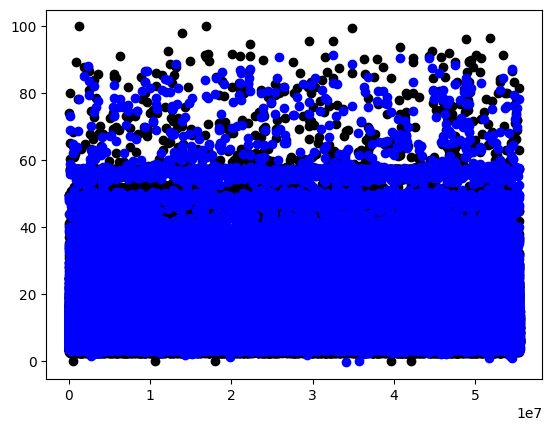

In [58]:
blend = cb_pred * 0.50 + lgbm_pred * 0.35 + xgb_pred * 0.15
rmse = mean_squared_error(y_test, blend, squared=True)
print('RMSE:', rmse)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, blend, color='blue');
plt.show()

## Stacking

In [59]:
X_stacking_train = pd.DataFrame()
X_stacking_train['catboost'] = cb_reg.predict(X_fs_train)
X_stacking_train['lgbm'] = lgbm_reg.predict(X_train)
X_stacking_train['xgb'] = xgb_reg.predict(X_train)
X_stacking_train.head(3)

,catboost,lgbm,xgb
0,5.934114,6.844797,6.784895
1,6.240180,6.508808,6.368842
2,6.173539,5.263165,5.931945


In [60]:
X_stacking_test = pd.DataFrame()
X_stacking_test['catboost'] = cb_pred
X_stacking_test['lgbm'] = lgbm_pred
X_stacking_test['xgb'] = xgb_pred
X_stacking_test.head(3)

,catboost,lgbm,xgb
0,7.576884,8.320916,8.001091
1,4.508215,4.203320,4.126583
2,5.900828,6.008397,6.455109


RMSE: 8.75361008854161
Coefficients: 
 [-0.27597952 -0.1506944   1.42551049]


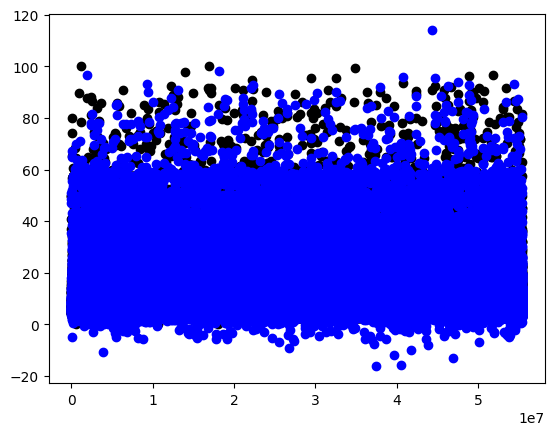

In [62]:
meta_linreg = LinearRegression()
meta_linreg.fit(X_stacking_train, y_train)
meta_linreg_pred = meta_linreg.predict(X_stacking_test)
rmse = mean_squared_error(y_test, meta_linreg_pred, squared=True)
print('RMSE:', rmse)

print("Coefficients: \n", meta_linreg.coef_)

plt.scatter(y_test.index, y_test.values, color='black');
plt.scatter(y_test.index, meta_linreg_pred, color='blue');
plt.show()